In [5]:
from pathlib import Path
import numpy as np
import datetime
import netCDF4
import matplotlib.pyplot as plt
import pyproj
import cartopy.feature as cfe
import cartopy.crs as ccrs
import pandas as pd
from pyproj import Transformer
from pyproj import CRS
from eofs.xarray import Eof
from shapely.geometry.polygon import Polygon
import shapefile as shp
import fiona 
import rioxarray
import geopandas as gpd
from shapely.geometry import mapping
import geoplot
from rasterio import features
from shapely.geometry import Point
import matplotlib.colors as colors
from numpy import ma
import xarray as xr
from sklearn.decomposition import PCA
from sklearn import preprocessing

# Functions

In [6]:
def plot_nearby_ice_shelves(shapefile,x_lims,y_lims):
    """
    Input: 
    shapefile -> shape file (Geopandas Dataframe format),
    x_lims -> minimum longitude and maximum longitude to search for ice shelves (Tuple)
    y_lims -> minimum latitude and maximum latitude to search for ice shelves (Tuple)
    
    Output:
    Returns a masked Geopandas Dataframe of ice shelves within the x_lims, y_lims defined
    Plots Graph with reference numbers
    """
    border = [(x_lims[0],y_lims[0]), (x_lims[1],y_lims[0]), (x_lims[1],y_lims[1]),(x_lims[0],y_lims[1])]
    bounds_poly=Polygon(shell=border)
    mask = shapefile['geometry'].apply(lambda x: bounds_poly.contains(x))
    within_bounds = (shapefile[mask])
    ax = within_bounds.plot(figsize=(12, 12))
    within_bounds.apply(lambda x: ax.annotate(text=x['recnum'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
    plt.show()
    return within_bounds

def read_file_paths(filename):
    this_dir=Path.cwd()
    data_dir=this_dir.parent/Path("Data")
    files = data_dir.rglob(filename)
    for i in files:
        data = i
    return data

def one_ice_shelf_only_mask(all_is,rn):
    """
    Input: 
    all_is -> Geopandas Dataframe of all ice shelves masked within a certain bound
    recnum-> the ref id needed for one particular ice_shelf
    Output: Geopandas Dataframe of just the one ice shelf defined by the record number rn
    """
    return all_is.loc[all_is.recnum==rn]

def ice_shelf_mask_rotate(ice_shelf,out_crs):
    """
    Input: 
    ice_shelf -> Geopandas Dataframe of just the one ice shelf
    out_crs-> the crs we want to convert the mask to
    Output: Geopandas Dataframe of just the one ice shelf defined by the record number rn
    """
    return ice_shelf.geometry.to_crs(data_crs)
    
def resample_summer(data,summer_months):
    """
    Input: 
    ds -> raw data set (XArray DataSet format),
    summer_months-> List for the years we want to filter
    Output:
    Returns a filtered XArray DataSet with only the summer months (Oct,Nov,Dec,Jan,Feb,Mar)
    """
    d2 = data.sel(time=data.time.dt.month.isin(summer_months))
    return d2

def reduce_spatial_data(ds,x_lims,y_lims,summer_months):
    """
    Input: 
    ds -> raw data set (XArray DataSet format),
    x_lims -> minimum longitude and maximum longitude to crop (Tuple)
    y_lims -> minimum latitude and maximum latitude to crop (Tuple)
    summer_months-> List for the years we want to filter
    
    Output:
    Returns a clipped XArray DataSet with only the summer months (Oct,Nov,Dec,Jan,Feb,Mar) and reduced space
    """
        
    summer_ds=resample_summer(ds,summer_months)
    minx,miny,maxx,maxy= transproj.transform_bounds(min(x_lims),min(y_lims),max(x_lims),max(y_lims))
    mask_lon = (summer_ds.rlon >= minx) & (summer_ds.rlon <= maxx)
    mask_lat = (summer_ds.rlat >= miny) & (summer_ds.rlat <= maxy)
    summer_ds= summer_ds.where(mask_lon & mask_lat, drop=True)
    return summer_ds

def masked_ds_only(ds_og,ds_masked,variable):
    """
    ds_og -> Original XArray Dataset that is masked
    ds_masked -> Xarray DataArray that is masked
    variable-> Variable to include (str)
    """
    ds_og=ds_og.drop_vars(variable)
    ds_og[variable] = ds_masked
    ds_og=ds_og.dropna(dim='rlat',how='all')
    ds_og=ds_og.dropna(dim='rlon',how='all')
    return ds_og

def resample_bounds(data,frequency):
    """
    resample data set to given frequency
    """
    d2=data.resample(time=frequency).mean()
    lat = d2['rlat'].values
    lon = d2['rlon'].values
    lons, lats = np.meshgrid(lon, lat)
    return d2,lons,lats

def mask_data(ds):
    ds['snowfall']=ds.snowfall.rio.set_spatial_dims(x_dim='rlon', y_dim='rlat', inplace=True)
    c=ds.snowfall.rio.write_crs(data_crs).rio.clip(geometries=rotated_mask.geometry.apply(mapping),crs=data_crs,all_touched=False,drop=True,from_disk=True)
    ds= masked_ds_only(ds,c,'snowfall')
    return ds

In [7]:
file2016='snowfall.KNMI-2016.XPEN055.ERA5-3H_RACMO2.3p2.3H.nc'
file2021='snowfall.KNMI-2021.XPEN055.ERA5-3H_RACMO2.3p2.3H.nc'
shape_name='my556bx0395.shx'

In [8]:
rd_2016=xr.open_dataset(read_file_paths(file2016)) 
rd_2021=xr.open_dataset(read_file_paths(file2021)) 
antarctica_shape = gpd.read_file(read_file_paths(shape_name))

In [9]:
rd_2016

<xarray.Dataset>
Dimensions:       (rlat: 294, rlon: 390, height: 1, nblock1: 40, nblock2: 400, time: 14616, bnds: 2)
Coordinates:
    lon           (rlat, rlon) float64 ...
    lat           (rlat, rlon) float64 ...
  * rlon          (rlon) float64 -32.0 -31.95 -31.9 ... -12.65 -12.6 -12.55
  * rlat          (rlat) float64 -8.7 -8.65 -8.6 -8.55 ... 5.8 5.85 5.9 5.95
  * height        (height) float64 0.0
  * time          (time) datetime64[ns] 2016-01-01 ... 2020-12-31T21:00:00
Dimensions without coordinates: nblock1, nblock2, bnds
Data variables:
    dir           (rlat, rlon) float64 ...
    block1        (nblock1) int32 ...
    block2        (nblock2) int32 ...
    time_bnds     (time, bnds) datetime64[ns] ...
    dtg           (time) int32 ...
    date_bnds     (time, bnds) int32 ...
    hms_bnds      (time, bnds) int32 ...
    assigned      (time) int32 ...
    rotated_pole  float32 ...
    snowfall      (time, height, rlat, rlon) float32 ...
Attributes:
    Conventions:   CF-1.4
    source:        RACMO2
    Domain:        XPEN055
    Experiment:    ERA5-3H_RACMO2.3p2
    institution:   Royal Netherlands Meteorological Institute (KNMI)
    CreationDate:  Fri Jun 18 19:37:58 2021
    comment:       asim2cdf: cpar=snowfall, iwmo=144, ilvt=105, ilev=0, idh=3...
    title:         Solid Precipitative Flux

In [10]:
data_crs=CRS('-m 57.295779506 +proj=ob_tran +o_proj=latlon +o_lat_p=-180.0 +lon_0=30.0 +o_lon_p=0')
from_lat_lon_crs = CRS.from_proj4("+proj=latlon")
transproj = Transformer.from_crs(from_lat_lon_crs, data_crs)

y_lim = (-75,-66) # latitude 
x_lim = (-78,-65) #longitude

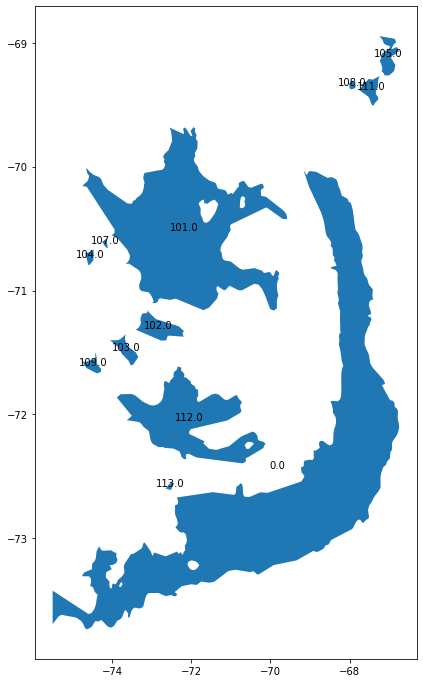

In [11]:
within_bounds=plot_nearby_ice_shelves(antarctica_shape,x_lim,y_lim)
gviis_mask=one_ice_shelf_only_mask(within_bounds,0)
rotated_mask=ice_shelf_mask_rotate(gviis_mask,data_crs)

rd_2016=reduce_spatial_data(rd_2016,x_lim,y_lim,[1, 2, 3, 10, 11, 12])
rd_2016=rd_2016[['snowfall']]

rd_2021=reduce_spatial_data(rd_2021,x_lim,y_lim,[1, 2, 3, 10, 11, 12])
rd_2021=rd_2021[['snowfall']]

In [12]:
rd_2016=mask_data(rd_2016)
rd_2021=mask_data(rd_2021)

In [13]:
snowfall_data = xr.concat([rd_2016, rd_2021],'time')

In [14]:
snowfall_data

<xarray.Dataset>
Dimensions:       (rlat: 46, rlon: 79, height: 1, time: 7768)
Coordinates:
  * rlat          (rlat) float64 -4.35 -4.3 -4.25 -4.2 ... -2.25 -2.2 -2.15 -2.1
  * rlon          (rlon) float64 -19.7 -19.65 -19.6 ... -15.9 -15.85 -15.8
    lon           (rlat, rlon) float64 -72.72 -72.75 -72.78 ... -67.65 -67.67
    lat           (rlat, rlon) float64 -69.84 -69.89 -69.94 ... -74.02 -74.06
  * height        (height) float64 0.0
  * time          (time) datetime64[ns] 2016-01-01 ... 2021-02-28T21:00:00
    rotated_pole  int32 0
Data variables:
    snowfall      (time, height, rlat, rlon) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:   CF-1.4
    source:        RACMO2
    Domain:        XPEN055
    Experiment:    ERA5-3H_RACMO2.3p2
    institution:   Royal Netherlands Meteorological Institute (KNMI)
    CreationDate:  Fri Jun 18 19:37:58 2021
    comment:       asim2cdf: cpar=snowfall, iwmo=144, ilvt=105, ilev=0, idh=3...
    title:         Solid Precipitative Flux

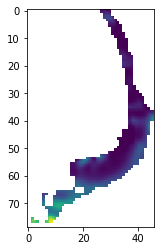

In [15]:
faceW = 79 #number of pixels in image width
faceH = 46 #number of pixels i|n image height


first_map = np.reshape(np.asarray(snowfall_data.snowfall.isel(time=1).values),(faceH,faceW)).T

plt.imshow(first_map)
plt.show()

In [16]:
filename='snowfall.nc'
this_dir=Path.cwd()
out_path=this_dir.parent/Path("Data/Cleaned and masked NETCDF files"+'/'+filename)

In [17]:
snowfall_data.snowfall.attrs

{'standard_name': 'snowfall_flux',
 'long_name': 'Solid Precipitative Flux',
 'units': 'kg m-2 s-1',
 'cell_methods': 'time: 3-hr averaged values',
 'grid_mapping': 'rotated_pole'}

In [18]:
del snowfall_data.snowfall.attrs['grid_mapping']
snowfall_data.to_netcdf(out_path)